In [30]:
import pymaid
import logging
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
from itertools import chain, combinations
from upsetplot import plot
from matplotlib import pyplot as plt
from networkx import from_numpy_array, number_of_nodes, number_of_edges, density
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.layouts import layout_tsne, layout_umap
from graspologic.plot.plot import networkplot
from graspologic.utils import is_fully_connected, largest_connected_component
from graspologic.simulations import sbm

In [2]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [3]:
skids = pymaid.get_skids_by_annotation("connectome")

In [4]:
skids

[2015233,
 1548290,
 1318919,
 2015241,
 1646603,
 1769485,
 1318929,
 1622033,
 2007060,
 1318938,
 1064990,
 1564703,
 1441826,
 1466405,
 1728550,
 139303,
 1671212,
 1417265,
 1728563,
 1318965,
 1278006,
 1466424,
 1458234,
 1417276,
 1564732,
 1507391,
 1294400,
 1671231,
 1065030,
 1318986,
 1294413,
 1441872,
 1327186,
 24659,
 1957973,
 1278038,
 1130583,
 1433691,
 1376350,
 1024095,
 1278051,
 1359971,
 1392742,
 1392754,
 1359987,
 385141,
 827510,
 1065083,
 1646725,
 1335430,
 1302663,
 2007173,
 786570,
 557195,
 909450,
 1736843,
 1319057,
 1384593,
 1204373,
 1433751,
 942233,
 1409181,
 1319070,
 57508,
 1409196,
 344239,
 1073332,
 1671351,
 1736887,
 1663161,
 1499326,
 401601,
 573635,
 2015432,
 1376459,
 1065166,
 57553,
 508114,
 1335507,
 671957,
 1425621,
 1065178,
 1286364,
 1155295,
 73954,
 1278185,
 1474793,
 1482990,
 1466608,
 1286389,
 1409275,
 1483005,
 1646847,
 1679615,
 1286402,
 409861,
 24849,
 139543,
 1483032,
 16668,
 532764,
 1311006,
 139292

In [5]:
adj = pymaid.adjacency_matrix(skids)
orig_ids = np.array(adj.index)
index = [1517,1979,2075,2146,2719]
new_ids = np.delete(orig_ids, index)
len(new_ids)

2723

In [6]:
adj = adj.to_numpy()
lcc_adj = largest_connected_component(adj)
print(lcc_adj)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
networkx_adj = from_numpy_array(adj)
print(networkx_adj)

Graph with 2728 nodes and 10846 edges


In [8]:
networkx_lcc = largest_connected_component(networkx_adj)
print(networkx_lcc.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [9]:
for node in networkx_adj.nodes():
    if node not in networkx_lcc.nodes():
        print(node)

1517
1979
2075
2146
2719


In [19]:
print(networkx_adj)

Graph with 2728 nodes and 10846 edges


In [38]:
X, node_pos = layout_tsne(networkx_adj, perplexity=100, n_iter=250)
print(len(node_pos))
x_pos = []
y_pos = []
node_ids = []
for pos in node_pos:
    node_ids.append(pos[4])
    x_pos.append(pos[1])
    y_pos.append(pos[2])

node_ids = np.array(node_ids)
x_pos = np.array(x_pos)
y_pos = np.array(y_pos)
degrees = np.sum(lcc_adj, axis=0)
degrees

2723


array([10.,  4.,  7., ...,  1.,  1.,  2.])

In [11]:
print(max(node_ids))

12


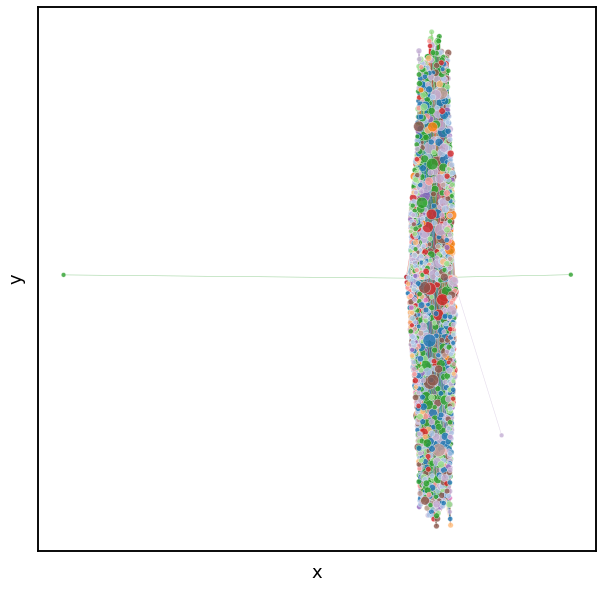

In [12]:
plot = networkplot(
    adjacency=lcc_adj,
    x=x_pos,
    y=y_pos,
    node_hue=node_ids,
    palette="tab20",
    node_size=degrees,
    node_sizes=(20, 200),
    edge_hue="source",
    edge_alpha=0.5,
    edge_linewidth=0.5,
)
plt.show()

In [13]:
X, node_pos = layout_umap(networkx_adj)
print(len(node_pos))
x_pos = []
y_pos = []
node_ids = []
for pos in node_pos:
    node_ids.append(pos[4])
    x_pos.append(pos[1])
    y_pos.append(pos[2])

node_ids = np.array(node_ids)
x_pos = np.array(x_pos)
y_pos = np.array(y_pos)
degrees = np.sum(lcc_adj, axis=0)

2723


In [14]:
print(max(node_ids))

14


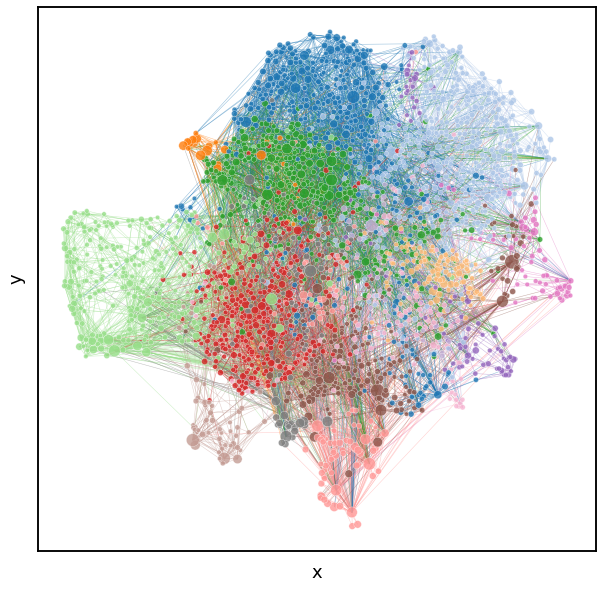

In [15]:
plot = networkplot(
    adjacency=lcc_adj,
    x=x_pos,
    y=y_pos,
    node_hue=node_ids,
    palette="tab20",
    node_size=degrees,
    node_sizes=(20, 200),
    edge_hue="source",
    edge_alpha=0.5,
    edge_linewidth=0.5,
)
plt.show()

In [44]:
def modularity_from_adjacency(sym_adj, partition, resolution=1):
    if isinstance(partition, dict):
        partition_labels = np.vectorize(partition.__getitem__)(
            np.arange(sym_adj.shape[0])
        )
    else:
        partition_labels = partition
    partition_labels = np.array(partition_labels)
    in_comm_mask = partition_labels[:, None] == partition_labels[None, :]
    degrees = np.squeeze(np.asarray(sym_adj.sum(axis=0)))
    degree_prod_mat = np.outer(degrees, degrees) / sym_adj.sum()
    mod_mat = sym_adj - resolution * degree_prod_mat
    return mod_mat[in_comm_mask].sum() / sym_adj.sum()

In [58]:
n_nodes = networkx_lcc.number_of_nodes()
n_edges = networkx_lcc.number_of_edges()
dens = density(networkx_lcc)
mod_score = modularity_from_adjacency(lcc_adj, node_ids)

In [59]:
sum = 0
for node in networkx_lcc.nodes():
    sum += networkx_lcc.degree(node)
avg_degree = sum/2723

In [62]:
stats = {"Number of nodes": n_nodes, "Number of edges": n_edges, "Graph density": dens, "Modularity": mod_score, "Avg. degree": avg_degree}
stats_df = pd.DataFrame.from_dict(stats, orient="index", columns=["P. dumerilii"])
stats_df

,P. dumerilii
Number of nodes,2723.000000
Number of edges,10846.000000
Graph density,0.002927
Modularity,0.644393
Avg. degree,7.966214


In [16]:
n_communities = [50, 50]
p = [[0.25, 0.05], [0.05, 0.25]]

np.random.seed(1)
A, node_ids = sbm(n_communities, p, return_labels=True)
print(A.shape)

(100, 100)


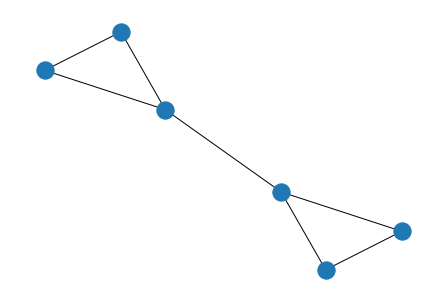

In [37]:
G = nx.barbell_graph(3,0)
nx.draw(G)